# K-Means Analysis

This notebook studies K-Means behaviours depending on the number of clusters set

## Initial settings

In [1]:
from cdalvaro.catalogues import OpenClust
from cdalvaro.data_base import DB
from cdalvaro.graphics import plot as cplt
from cdalvaro.logging import Logger
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

In [2]:
logger = Logger.instance()
logger.setLevel(logging.ERROR)

db = DB.instance(host='gaia.cdalvaro.io', port=15432)

figures_path = "../../figures"
save_dir = './results'

clusters = OpenClust.catalogue()

## Feature selection

In [3]:
variables = [
    "ra", "ra_error", "dec", "dec_error", "pmra", "pmra_error",
    "pmdec", "pmdec_error", "parallax", "parallax_error",
    "phot_g_mean_mag", "bp_rp"
]

non_null_columns = list(filter(lambda x: not re.search(r'_error', x), variables))

## Stars selection

In [4]:
cluster_name = "Melotte 22"

cluster = clusters[cluster_name]
stars_df = db.get_stars(region=cluster, columns=variables, filter_null_columns=non_null_columns)

stars_df = stars_df[(np.abs(stars_df['pmra']) > 0.0)
                    & (np.abs(stars_df['pmdec']) > 0.0)
                    & (np.abs(stars_df['parallax']) > 0.0)]

stars_df['pmra_corr'] = stars_df['pmra'] * 1000.0 / stars_df['parallax']
stars_df['pmdec_corr'] = stars_df['pmdec'] * 1000.0 / stars_df['parallax']

stars_df['pmmod'] = np.sqrt(stars_df['pmra_corr'] ** 2 + stars_df['pmdec_corr'] ** 2)
stars_df['pmang'] = np.arctan2(stars_df['pmdec_corr'], stars_df['pmra_corr'])

## Feature selection

In [5]:
features = ['pmra_corr', 'pmdec_corr', 'pmmod', 'parallax']

## Feature rescaling

In [6]:
scaler = MinMaxScaler()
x = scaler.fit_transform(stars_df[features])

## K-Means

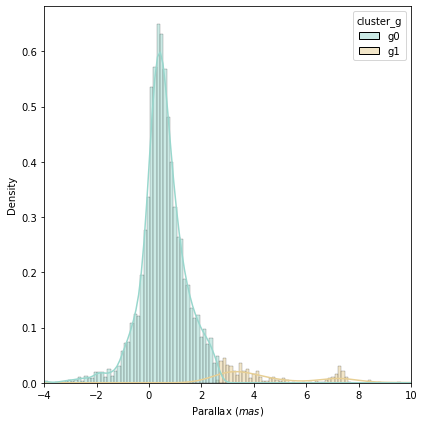

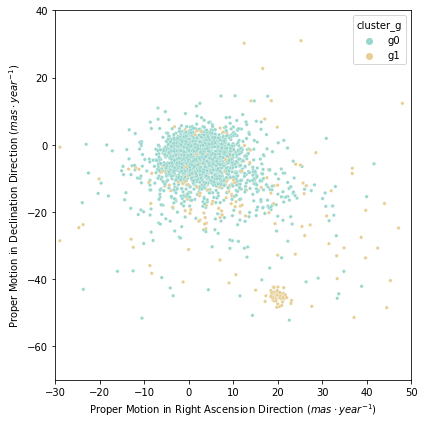

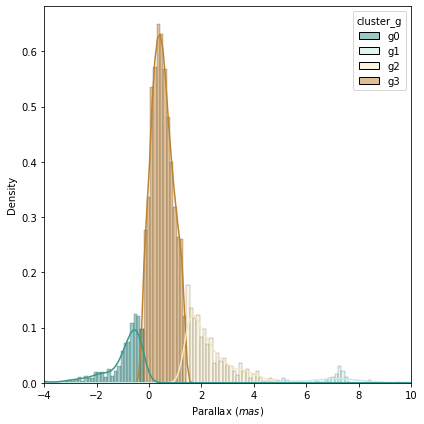

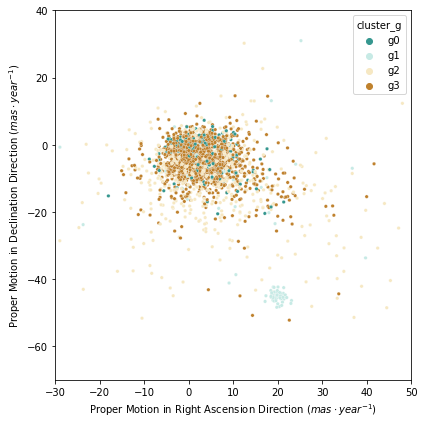

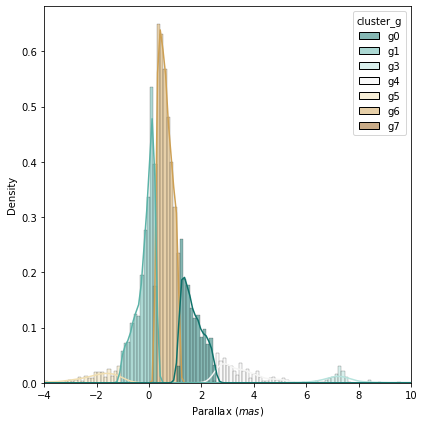

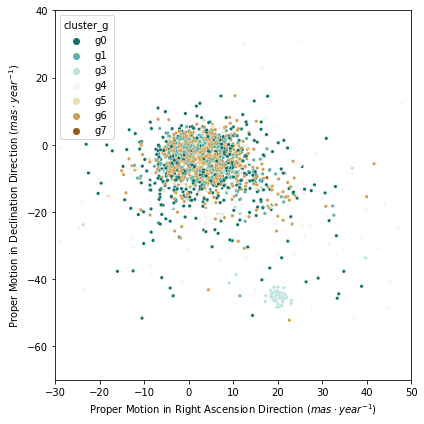

In [7]:
for n_clusters in [2, 5, 8]:
    kmeans = KMeans(n_clusters=n_clusters)
    stars_df['cluster_g'] = np.array([f"g{g}" for g in kmeans.fit_predict(x)], dtype=str)

    # Parallax
    fig, ax, g = cplt.plot_cluster_parallax_histogram(stars_df, xlim=(-4, 10), stat='density')
    cplt.save_figure(fig, name=f"kmeans_n{n_clusters}_parallax_{cluster.name}", save_dir=figures_path)

    # Proper motion
    fig, ax, g = cplt.plot_cluster_proper_motion(stars_df, xlim=(-30, 50), ylim=(-70, 40))
    cplt.save_figure(fig, name=f"kmeans_n{n_clusters}_pm_{cluster.name}", save_dir=figures_path)